In [84]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
import random
#import sklearn.model_selection as train_test_split

# Graphic
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn Tree lib
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

# Bagging & Bootstrapping
from sklearn.ensemble import BaggingClassifier

# Validation
from sklearn.metrics import explained_variance_score

In [138]:
df_train = pd.read_csv("data/house-pricing.csv")
df_test = pd.read_csv("data/test.csv")
print("TRAIN SIZE: \n", df_train.shape)
print("TEST SIZE: \n", df_test.shape)

TRAIN SIZE: 
 (1460, 81)
TEST SIZE: 
 (1459, 80)


### GENERATE VALIDATION DATASET

In [139]:
train_df, validation_df = train_validation_split(df_train, test_size=0.3)
print("TRAIN SIZE: \n", train_df.shape)
print("VALIDATION SIZE: \n", validation_df.shape)

TRAIN SIZE: 
 (1022, 81)
VALIDATION SIZE: 
 (438, 81)


In [122]:
def train_validation_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

In [123]:
#print(df_train.info())

In [124]:
def category2Int(df):
    for feature in df.columns:
        if df[feature].dtype == 'object':
            counts = df[feature].value_counts()
            df[feature] = [counts.index.tolist().index(i) 
                        if i in counts.index.tolist() 
                        else 0 
                        for i in df[feature] ]
    return df

### CONVERTING CATEGORIES TO INTEGER

In [140]:
train_df = category2Int(df_train)
validation_df = category2Int(validation_df)
test_df = category2Int(df_test)

In [126]:
df_train.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,0,65.0,8450,0,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,2,20,0,80.0,9600,0,0,0,0,0,...,0,0,0,0,0,5,2007,0,0,181500
2,3,60,0,68.0,11250,0,0,1,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,4,70,0,60.0,9550,0,0,1,0,0,...,0,0,0,0,0,2,2006,0,2,140000
4,5,60,0,84.0,14260,0,0,1,0,0,...,0,0,0,0,0,12,2008,0,0,250000
5,6,50,0,85.0,14115,0,0,1,0,0,...,0,0,0,0,700,10,2009,0,0,143000
6,7,20,0,75.0,10084,0,0,0,0,0,...,0,0,0,0,0,8,2007,0,0,307000
7,8,60,0,NaN,10382,0,0,1,0,0,...,0,0,0,0,350,11,2009,0,0,200000
8,9,50,1,51.0,6120,0,0,0,0,0,...,0,0,0,0,0,4,2008,0,2,129900
9,10,190,0,50.0,7420,0,0,0,0,0,...,0,0,0,0,0,1,2008,0,0,118000


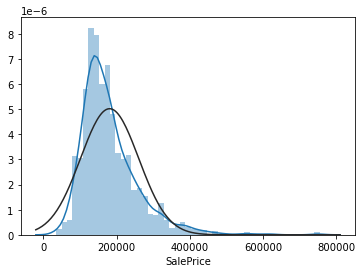

In [127]:
from scipy.stats import norm
sns.distplot(train_df['SalePrice'], fit=norm)

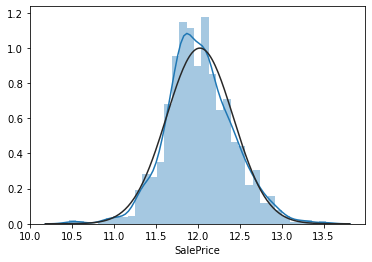

In [128]:
sns.distplot(np.log(train_df['SalePrice']), fit=norm)

### FEATURES SELECTION

In [129]:
included_features = ['MoSold','YrSold','LotArea','BedroomAbvGr', # original data
                    'FullBath','HalfBath','TotRmsAbvGrd', # bathrooms and total rooms
                    'YearBuilt','YearRemodAdd', # age of the house
                    'LotShape','Utilities']
X = train_df[included_features]
Y = np.log(train_df[['SalePrice']])

#print("X: \n", X.head(10))
#print("Y: \n", Y.head(10))

### Bootstrapping & Subsample

In [130]:
def bootstrappping(train_df, n_bootstrap):
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstrapped = train_df.iloc[bootstrap_indices]
    return df_bootstrapped

In [131]:
def random_forest_algorithms(train_df, n_trees, n_bootstrap, included_features):
    forest = [] # Tập các tree
    
    for i in range(n_trees):
        df_bootstrapping = bootstrappping(train_df, n_bootstrap)
        
        bsX = df_bootstrapping[included_features]
        bsY = df_bootstrapping['SalePrice']
        
        tree = DecisionTreeRegressor(max_depth=None)
        tree.fit(bsX, bsY)
        
        forest.append(tree)
    return forest

In [132]:
dataframe_train = pd.concat([X, Y], axis=1)
dataframe_train

,MoSold,YrSold,LotArea,BedroomAbvGr,FullBath,HalfBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,LotShape,Utilities,SalePrice
0,2,2008,8450,3,2,1,8,2003,2003,0,0,12.247694
1,5,2007,9600,3,2,0,6,1976,1976,0,0,12.109011
2,9,2008,11250,3,2,1,6,2001,2002,1,0,12.317167
3,2,2006,9550,3,1,0,7,1915,1970,1,0,11.849398
4,12,2008,14260,4,2,1,9,2000,2000,1,0,12.429216
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,8,2007,7917,3,2,1,7,1999,2000,0,0,12.072541
1456,2,2010,13175,3,2,0,7,1978,1988,0,0,12.254863
1457,5,2010,9042,4,2,0,9,1941,2006,0,0,12.493130
1458,4,2010,9717,2,1,0,5,1950,1996,0,0,11.864462


In [133]:
forest = random_forest_algorithms(dataframe_train.fillna(0), n_trees=80, n_bootstrap=1000, included_features=included_features)

### PREDICT FROM MODEL

In [144]:
def forest_predict(forest, test_df):
    
    # Lưu lại các dự đoán của các Cây quyết định trong N tập test_df
    forest_predictions = []
    for i in range(len(forest)):
        tree = forest[i]
        prediction = tree.predict(test_df)
        forest_predictions.append(prediction)
    # Convert sang numpy
    forest_predictions = np.array(forest_predictions)
    
    # Trung bình cộng các dự đoán từ các Cây quyết định
    prediction = []
    for i in range(len(test_df)):
        predict_result = np.mean(forest_predictions[:, i])
        prediction.append(predict_result)
        
    print("Number of result: {0}".format(len(prediction)))
    #print("Results: \n", house_pricing_prediction)
    return prediction

test_df = test_df[included_features]
predictions = forest_predict(forest, test_df.fillna(0)) # 1459 TEST SAMPLES
predictions = np.exp(predictions)
predictions[0]

Number of result: 1459


126075.63262626613

### VALIDATION THE MODEL

In [145]:
# Công thức: 1 - var(y - y^) / var(y)
def explained_variance(y_true, y_predict):
    score = explained_variance_score(y_true, y_predict) 
    return score

In [158]:
def validation(forest, validation_df):
    X_validation = validation_df[included_features]
    Y_validation = validation_df['SalePrice'] # y_true
    
    y_predict = forest_predict(forest, X_validation)
    
    '''
    print("Length of TRUE Y: ", len(Y_validation))
    print("Length of TRUE Y: ", np.log(Y_validation))
    
    print("Length of PREDICT Y: ", len(y_predict))
    print("Length of PREDICT Y: ", y_predict)
    '''
    return explained_variance(np.log(Y_validation), np.array(y_predict))

scores = validation(forest, validation_df.fillna(0))
print("Accuracy: {0} %".format(scores*100))

Number of result: 438
Accuracy: 92.4317884749562 %
